# How does Othello-GPT edit its world model?

In [1]:
# imports
import transformer_lens as lens
from transformer_lens import HookedTransformer, HookedTransformerConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from fancy_einsum import einsum

/home/aidan/Documents/Programming/autocircuit/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get model from hf
model = HookedTransformer.from_pretrained("othello-gpt")

Loaded pretrained model othello-gpt into HookedTransformer


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# get Neel Nanda's linear probes and convert them to the HookedTransformer format
# going to focus on layer 6 because apparently that one works pretty good
probe = torch.load("main_linear_probe.pth", map_location=device)

In [5]:
# indexing
itos = [-100] + list(range(0,27)) + list(range(30,35)) + list(range(37,64))
stoi = {s:i for i,s in enumerate(itos)}


rows = list("abcdefgh")
columns = [str(_) for _ in range(1, 9)]

def permit(s):
    s = s.lower()
    if len(s) != 2:
        return -1
    if s[0] not in rows or s[1] not in columns:
        return -1
    return rows.index(s[0]) * 8 + columns.index(s[1])

import textwrap

In [6]:
# test linear probe
moves = textwrap.wrap("C4c3D3", 2)
tokens = torch.tensor([stoi[permit(move)] for move in moves]).unsqueeze(0).to(device)

# get activations
_, cache = model.run_with_cache(tokens)

# get activations for layer 6
activations = cache["resid_post", 6]

"""
# get board state predictions
probe_out = einsum(
    "batch pos d_model, modes d_model rows cols options -> modes batch pos rows cols options",
    activations,
    probe,
)

probe_log_probs = probe_out.log_softmax(-1)

print(probe_log_probs.shape)

board_state = np.zeros((8, 8))

for i in range(8):
    for j in range(8):
        board_state[i, j] = np.exp(probe_log_probs[2, -1, -1, i, j, 0].item())
"""

'\n# get board state predictions\nprobe_out = einsum(\n    "batch pos d_model, modes d_model rows cols options -> modes batch pos rows cols options",\n    activations,\n    probe,\n)\n\nprobe_log_probs = probe_out.log_softmax(-1)\n\nprint(probe_log_probs.shape)\n\nboard_state = np.zeros((8, 8))\n\nfor i in range(8):\n    for j in range(8):\n        board_state[i, j] = np.exp(probe_log_probs[2, -1, -1, i, j, 0].item())\n'

In [7]:
cf_moves = "C4c3E6"
cf_tokens = torch.tensor([stoi[permit(move)] for move in textwrap.wrap(cf_moves, 2)]).unsqueeze(0).to(device)
_, cf_cache = model.run_with_cache(cf_tokens)

def diff(x, y):
    #print(x, y)
    return F.mse_loss(x, y)

In [8]:
# generate activations and the graph
import autocircuit.transformer_lens as ac_lens

ac_model = ac_lens.Transformer(model, model.cfg, 3)

In [9]:
print(ac_model.graph.nodes["0.6.resid_post"].hook_point)

blocks.6.hook_resid_post


In [10]:
print(cf_tokens.shape)
cf_act = ac_model.run_with_cache(model, cf_tokens)
#normal_act = ac_model.run_with_cache(model, tokens)

torch.Size([1, 3])
dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook

In [11]:
import autocircuit as ac

with torch.no_grad():
    out = ac.autocircuit(ac_model, ac_model.graph, "output", tokens, cf_act, 1, ablation_mode="zero")

output has important children ['0.7.resid_post', '1.7.resid_post', '2.7.resid_post'] and mean diff 2.4995203018188477
0.7.resid_post has important children ['0.7.mlp_out', '0.7.resid_mid'] and mean diff 2.454843044281006
1.7.resid_post has important children ['1.7.mlp_out', '1.7.resid_mid'] and mean diff 2.454843044281006
2.7.resid_post has important children ['2.7.mlp_out', '2.7.resid_mid'] and mean diff 2.454843044281006
0.7.mlp_out has important children ['0.7.resid_mid'] and mean diff 2.7679433822631836
0.7.resid_mid has important children ['0.6.resid_post', '0.7.reader.0', '0.7.reader.1', '0.7.reader.2', '0.7.reader.3', '0.7.reader.4', '0.7.reader.5', '0.7.reader.6', '0.7.reader.7'] and mean diff 2.206434302859836
1.7.mlp_out has important children ['1.7.resid_mid'] and mean diff 2.7679433822631836
1.7.resid_mid has important children ['1.6.resid_post', '1.7.reader.0', '1.7.reader.1', '1.7.reader.2', '1.7.reader.3', '1.7.reader.4', '1.7.reader.5', '1.7.reader.6', '1.7.reader.7'] a

In [15]:
print(list(ac.all_tensors.values())[0] - list(ac.all_tensors.values())[1])

TypeError: 'dict_values' object is not subscriptable

NetworkXError: Node '0.0.writer.0.q' has no position.

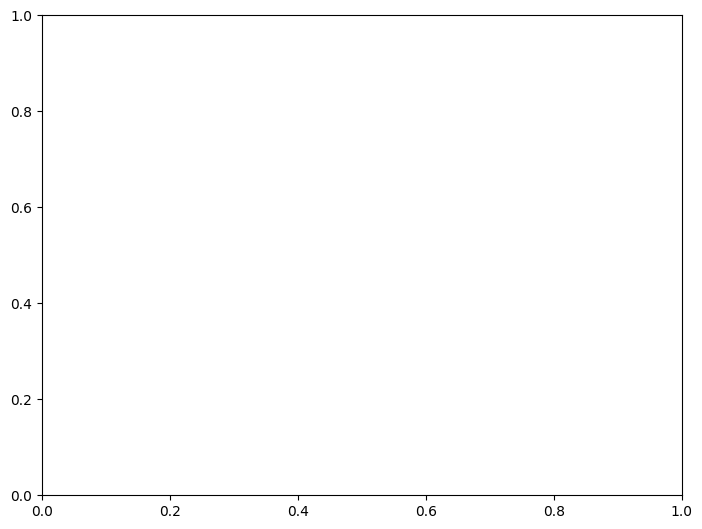

In [13]:
import autocircuit.visualise as vis

vis.draw_graph(out, ac_model.cfg)

In [ ]:
import autocircuit as ac

def diff_fn(x, y):
        return F.mse_loss(x, y)

#with torch.no_grad():
#    out = ac.path_tracing(ac_model, ac_model.graph, "2.7.resid_post", tokens, normal_act, cf_act, diff_fn, 0.01, "sample")
#    print(out)

In [ ]:
#import autocircuit.visualise as vis
#vis.draw_graph(out, ac_model.cfg)

In [ ]:
print(probe.shape)

torch.Size([3, 512, 8, 8, 3])


In [ ]:
import autocircuit.graphed_model as gm

probe_hook = gm.PartialHook(
    "blocks.6.hook_resid_post",
    lambda x: einops.einsum(
        x[:, 2],
        probe,
        "batch d_model, modes d_model rows cols options -> modes batch rows cols options"
    )[2, :, 4, 2, 1],
    lambda x, y: y,
)

ac_model_probed = ac_lens.ProbedTransformer(model, model.cfg, 3, probe_hook, "2.6.resid_post")

In [ ]:
cf_act = ac_model_probed.run_with_cache(model, cf_tokens)
normal_act = ac_model_probed.run_with_cache(model, tokens)

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'block

In [ ]:
with torch.no_grad():
    out = ac.path_tracing(ac_model_probed, ac_model_probed.graph, "probe", tokens, normal_act, cf_act, diff_fn, 0.005, "sample")

tracing probe
diff 17.135488510131836 > 0.005 for 2.6.resid_post of probe
tracing 2.6.resid_post
diff 0.6660007834434509 > 0.005 for 2.6.mlp_out of 2.6.resid_post
diff 1.3381656408309937 > 0.005 for 2.6.resid_mid of 2.6.resid_post
tracing 2.6.mlp_out
diff 0.6660007834434509 > 0.005 for 2.6.resid_mid of 2.6.mlp_out
tracing 2.6.resid_mid
diff 0.5092931985855103 > 0.005 for 2.5.resid_post of 2.6.resid_mid
tracing 2.5.resid_post
diff 0.10749679803848267 > 0.005 for 2.5.mlp_out of 2.5.resid_post
diff 0.5001432299613953 > 0.005 for 2.5.resid_mid of 2.5.resid_post
tracing 2.5.mlp_out
diff 0.10749679803848267 > 0.005 for 2.5.resid_mid of 2.5.mlp_out
tracing 2.5.resid_mid
diff 0.3117715120315552 > 0.005 for 2.4.resid_post of 2.5.resid_mid
tracing 2.4.resid_post
diff 0.04397646337747574 > 0.005 for 2.4.mlp_out of 2.4.resid_post
diff 0.29524368047714233 > 0.005 for 2.4.resid_mid of 2.4.resid_post
tracing 2.4.mlp_out
diff 0.04397645965218544 > 0.005 for 2.4.resid_mid of 2.4.mlp_out
tracing 2.4.res

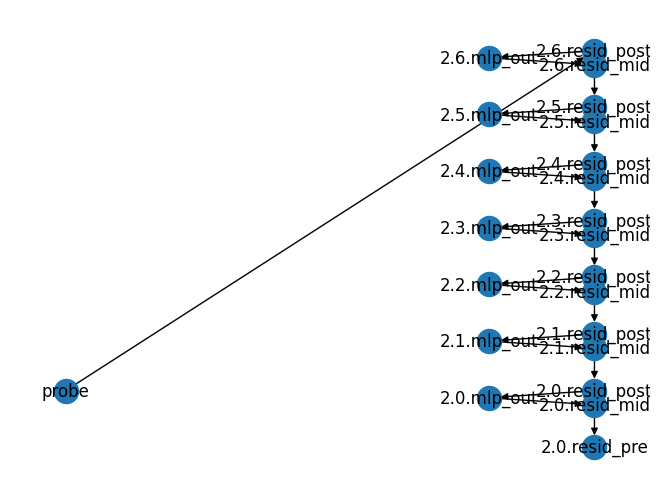

In [ ]:
import autocircuit.visualise as vis
vis.draw_graph(out, ac_model_probed.cfg)